In [1]:
import pandas as pd
import numpy as np
import datetime
import math

In [2]:
inp = pd.read_parquet('/Users/angad/Downloads/BTC-USDT.parquet',engine = 'pyarrow')
inp.reset_index(level=0,inplace=True)
inp.shape

(1828151, 10)

In [3]:
#Keep the important columns only
df = inp[['open_time','open','high','low','close','volume']]


In [4]:
#Start from 0:0:0 on 18th Aug 2017, rmeove partial data of 17th Aug 2017
df = df[df['open_time']>=datetime.datetime(2017,8,18,0,0)]
df.reset_index(inplace =True,drop=True)
df.shape


(1826951, 6)

In [5]:
df.head(30)

,open_time,open,high,low,close,volume
0,2017-08-18 00:00:00,4285.080078,4285.080078,4285.080078,4285.080078,0.022196
1,2017-08-18 00:01:00,4285.080078,4285.080078,4285.080078,4285.080078,0.463420
2,2017-08-18 00:02:00,4285.080078,4285.080078,4285.080078,4285.080078,0.215048
3,2017-08-18 00:03:00,4285.080078,4287.089844,4285.080078,4287.089844,0.926866
4,2017-08-18 00:04:00,4287.089844,4287.089844,4287.089844,4287.089844,1.335457
5,2017-08-18 00:05:00,4267.779785,4290.569824,4267.779785,4290.569824,3.928621
6,2017-08-18 00:06:00,4290.569824,4290.569824,4290.569824,4290.569824,0.519288
7,2017-08-18 00:07:00,4290.569824,4290.569824,4290.569824,4290.569824,0.665807
8,2017-08-18 00:08:00,4290.569824,4292.100098,4290.569824,4292.100098,0.406305
9,2017-08-18 00:09:00,4292.100098,4292.100098,4292.100098,4292.100098,0.000000


In [6]:
#Prepare data for different timeframe candles

def convert_min_hr_day(str):
    last_char = str[-1]
    rem_char = int(str[:-1])
    
    if last_char =='m':
        time_unit = 1*rem_char
    elif last_char == 'h':
        time_unit = 60*rem_char
    elif last_char == 'd':
        time_unit = 24*60*rem_char
    else:
        time_unit=0
    print("time_unit:",time_unit)
    return time_unit

In [7]:
def prepare_data(df,time):
    row_count = df.shape[0]
    time_unit = convert_min_hr_day(time)
    no_of_levels = math.ceil(row_count/time_unit)
    levels_list = list(range(1,no_of_levels+1))
    levels_list_expand = sorted(levels_list*time_unit)
    group_final_list = levels_list_expand[:row_count]
    
    df2 = df.copy()
    df2.insert(0,'group',group_final_list)
    
    output = pd.DataFrame()
    
    output['open'] = df2.groupby(['group']).first().open
    output['high'] = df2.groupby(['group'])['high'].max()
    output['low'] = df2.groupby(['group'])['low'].min()
    output['close'] = df2.groupby(['group']).last().close
    output['volume'] = df2.groupby(['group'])['volume'].sum()
    output['date'] = df2.groupby(['group']).first().open_time
    output['date'] = pd.to_datetime(output['date'])
    #output['date'] = output['date'].dt.date
    output.index= output['date']
    
    
    
    print('output_shape:',output.shape)
    return output
    
    

In [8]:
output = prepare_data(df,'15d')

time_unit: 21600
output_shape: (85, 6)


In [9]:
output.head(10)

,open,high,low,close,volume,date
date,,,,,,
2017-08-18 00:00:00.000,4285.080078,4885.549805,3400.000000,4834.910156,9781.156250,2017-08-18 00:00:00.000
2017-09-02 00:00:00.000,4834.910156,4939.189941,2817.000000,3563.050049,15615.473633,2017-09-02 00:00:00.000
2017-09-17 07:01:00.000,3563.050049,4560.000000,3499.020020,4452.870117,12384.630859,2017-09-17 07:01:00.000
2017-10-02 07:01:00.000,4452.870117,5922.299805,4110.000000,5640.140137,14366.750000,2017-10-02 07:01:00.000
2017-10-17 07:01:00.000,5640.140137,6498.009766,5037.950195,6415.000000,26682.109375,2017-10-17 07:01:00.000
2017-11-01 07:01:00.000,6414.819824,7770.020020,5325.009766,7283.419922,33249.980469,2017-11-01 07:01:00.000
2017-11-16 07:01:00.000,7283.419922,11300.030273,7250.060059,9435.990234,76445.593750,2017-11-16 07:01:00.000
2017-12-01 07:01:00.000,9431.030273,17991.000000,9380.000000,17625.650391,142968.046875,2017-12-01 07:01:00.000
2017-12-16 07:01:20.799,17625.650391,19798.679688,10961.000000,12707.230469,256789.375000,2017-12-16 07:01:20.799


# Candlestick plot using matplotlib

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loading data into dataframe:

# Converting the dates from string to datetime format:
output.index = pd.to_datetime(output.index)

# We need to exctract the OHLC prices into a list of lists:
dvalues = output[['open', 'high', 'low', 'close']].values.tolist()

# Dates in our index column are in datetime format, we need to comvert them 
# to Matplotlib date format (see https://matplotlib.org/3.1.1/api/dates_api.html):
pdates = mdates.date2num(output.index)

# If dates in our index column are strings instead of datetime objects, we should use:
# pdates = mpl.dates.datestr2num(data.index)

# We prepare a list of lists where each single list is a [date, open, high, low, close] sequence:
ohlc = [ [pdates[i]] + dvalues[i] for i in range(len(pdates)) ]

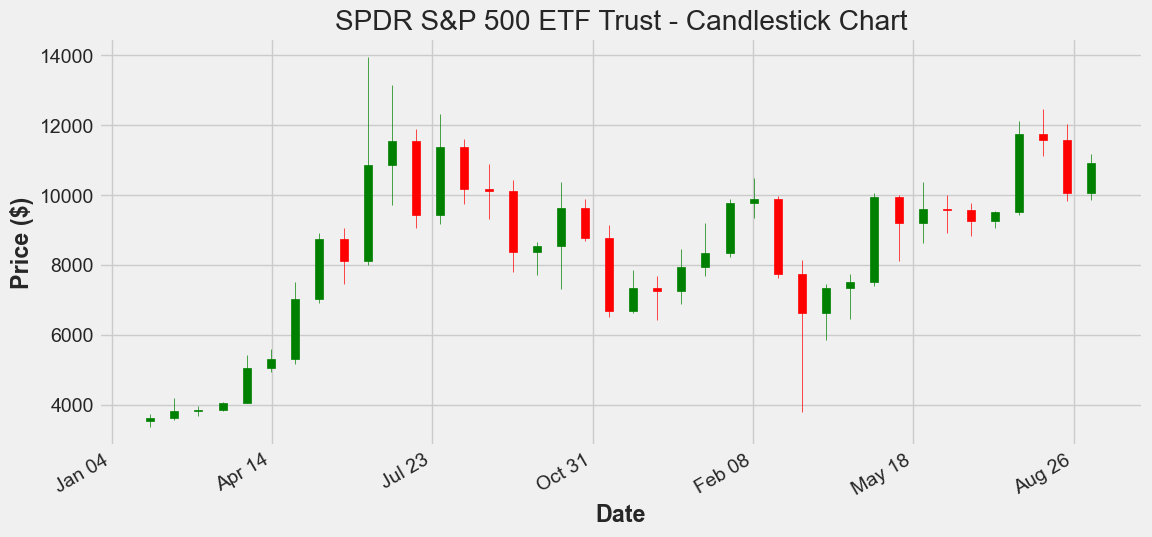

In [42]:
import mpl_finance as mpf # This is the old mpl-finance library - note the '_' in the library name

# We can now feed the ohlc matrix into mpl-finance to create a candle stick chart:

#plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize = (12,6))

mpf.candlestick_ohlc(ax, ohlc[-50:-10], width=5,colorup='g',colordown='r')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('SPDR S&P 500 ETF Trust - Candlestick Chart')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

fig.autofmt_xdate()

# plt.show() # add this if you're not using Jupyter Notebook

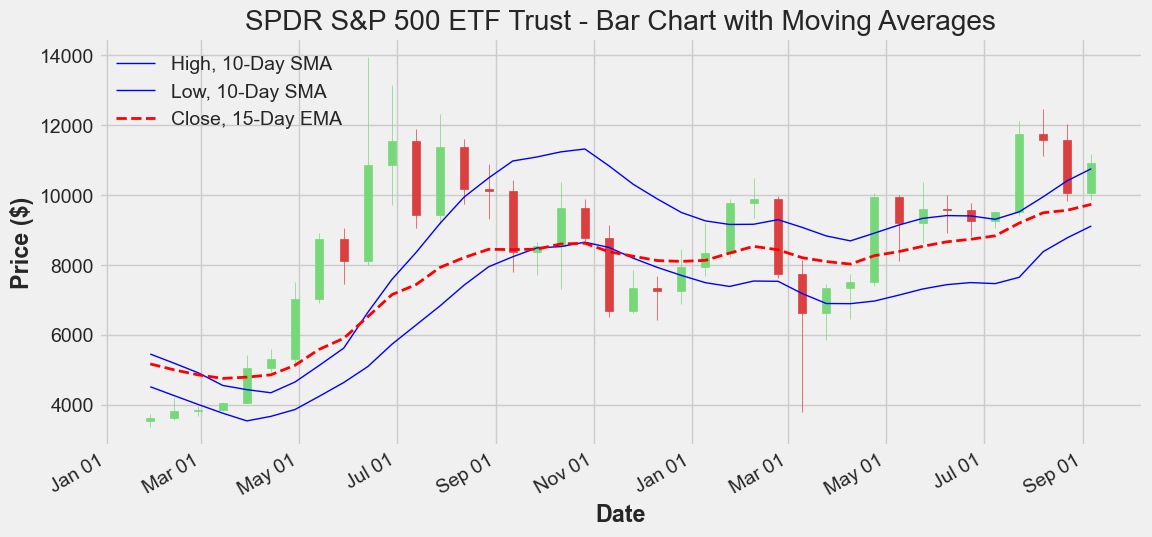

In [47]:
hsma40 = output['high'].rolling(10).mean()
lsma40 = output['low'].rolling(10).mean()
ema15 = output['close'].ewm(span=15).mean()

fig, ax = plt.subplots(figsize = (12,6))

mpf.candlestick_ohlc(ax, ohlc[-50:-10], width = 5,colorup='#77d879', colordown='#db3f3f')
ax.plot(hsma40[-50:-10], color = 'blue', linewidth = 1, label='High, 10-Day SMA')
ax.plot(lsma40[-50:-10], color = 'blue', linewidth = 1, label='Low, 10-Day SMA')
ax.plot(ema15[-50:-10], color = 'red', linestyle='--', linewidth = 2, label='Close, 15-Day EMA')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('SPDR S&P 500 ETF Trust - Bar Chart with Moving Averages')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.autofmt_xdate()
plt.show()

import mplfinance as fplt


fplt.plot(
            output,
            type='candle',
            style='charles',

            title='Candlestick chart for BTC-USDT',
            ylabel='Price ($)',
            volume=True,
            mav = 2,
            #savefig = 'plot.png'
        )

import plotly.graph_objects as go

candlestick = go.Candlestick(
                            x=output.index,
                            open=output['open'],
                            high=output['high'],
                            low=output['low'],
                            close=output['close']
                            )

fig = go.Figure(data=[candlestick])

fig.show()


import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)


output.iplot(kind="candle",
                          keys=["open", "high", "low", "close"],
                          rangeslider=True
                          )

#apple_df = pd.read_csv('/datasets/AAPL.csv', index_col=0, parse_dates=True)

qf=cf.QuantFig(output,title='BTC-USDT data',legend='top',name='plot')

qf.add_bollinger_bands()
qf.add_volume()
#qf.add_resistance(date = '2018-03-17')
#qf.add_support(date = '2018-03-17')
#qf.add_trendline(date0 = '2017-11-15',date1 ='2020-12-04',text ='Trend')
#qf.add_volume()

fig, ax = plt.subplots()
qf.iplot()
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
for level in levels:
    plt.hlines(level[1],xmin=output['date'][level[0]],\
               xmax=max(output['date']),colors='blue')
fig.show()

# qf.iplot()

output

output['date'] = pd.to_datetime(output.index)
output['date'] = output['date'].apply(mpl_dates.date2num)

output = output.loc[:,['date', 'open', 'high', 'low', 'close']]

output.head()

import os
os.system('say "Vaccine slot found"')

os.system('beep -f %s -l %s' % (1000, 2000))

#!pip install yfinance
!pip install mplfinance

import pandas as pd
import numpy as np
import yfinance
from mpl_finance import candlestick_ohlc
%matplotlib inline

import matplotlib.dates as mpl_dates

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

output.head()

In [130]:
output['date'] =pd.to_datetime(output['date'])
output['date'] = output['date'].dt.date
output.head()

,date,open,high,low,close
date,,,,,
2017-08-18 00:00:00,1970-01-01,4285.080078,4885.549805,3400.000000,4834.910156
2017-09-02 00:00:00,1970-01-01,4834.910156,4939.189941,2817.000000,3563.050049
2017-09-17 07:01:00,1970-01-01,3563.050049,4560.000000,3499.020020,4452.870117
2017-10-02 07:01:00,1970-01-01,4452.870117,5922.299805,4110.000000,5640.140137
2017-10-17 07:01:00,1970-01-01,5640.140137,6498.009766,5037.950195,6415.000000


def isSupport(df,i):
  support = df['low'][i] < df['low'][i-1]  and df['low'][i] < df['low'][i+1] and df['low'][i+1] < df['low'][i+2] and df['low'][i-1] < df['low'][i-2]
  return support
def isResistance(df,i):
  resistance = df['high'][i] > df['high'][i-1]  and df['high'][i] > df['high'][i+1] and df['high'][i+1] > df['high'][i+2] and df['high'][i-1] > df['high'][i-2]
  return resistance

levels = []
for i in range(2,output.shape[0]-2):
  if isSupport(output,i):
    levels.append((i,output['low'][i]))
  elif isResistance(output,i):
    levels.append((i,output['high'][i]))

def plot_all():
  fig, ax = plt.subplots()

  candlestick_ohlc(ax,output.values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)

  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()

  fig.tight_layout()

  for level in levels:
    plt.hlines(level[1],xmin=output['date'][level[0]],\
               xmax=max(output['date']),colors='blue')
  #fig.show()


plot_all()

levels